# Results Summary Analysis (Reader-Friendly)

This notebook turns `results_summary_by_settings.csv` into a compact, readable analysis report.

## What you will get
- Data quality checks and coverage overview
- Method-level long-format table for comparisons
- Main comparison plot under a configurable filter slice
- Best setting per method and pairwise deltas
- Optional CSV exports for downstream reporting


## 1) Setup

Imports and display settings used throughout the notebook.


In [36]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 220)
pd.set_option('display.precision', 3)


## 2) Load Data

We load the summary CSV and preview the first few rows.


In [37]:
CSV_PATH = Path('results_summary_by_settings.csv')
assert CSV_PATH.exists(), f'Missing file: {CSV_PATH}'

df = pd.read_csv(CSV_PATH)
print(f'Loaded {CSV_PATH} with shape: {df.shape}')
display(df.head(5))


Loaded results_summary_by_settings.csv with shape: (391, 24)


,dataset,degree,gt,gen,label_source,em_match,em_select,em_ensemble,n_rows,n_files,n_seeds,goat_mean,goat_std,goat_count,goatcw_mean,goatcw_std,goatcw_count,eta_mean,eta_std,eta_count,ours_fr_mean,ours_fr_std,ours_fr_count,seeds
0,colored_mnist,NaN,0,0,pseudo,prototypes,bic,False,3,3,3,61.340,0.352,3,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0,0|1|2
1,colored_mnist,NaN,0,0,pseudo,prototypes,bic,True,3,3,3,61.340,0.352,3,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0,0|1|2
2,colored_mnist,NaN,0,1,pseudo,prototypes,bic,False,3,3,3,72.227,2.870,3,62.467,7.200,3,49.873,4.417,3,68.627,3.737,3,0|1|2
3,colored_mnist,NaN,0,1,pseudo,prototypes,bic,True,3,3,3,72.227,2.870,3,58.933,0.304,3,54.490,6.323,3,68.730,3.545,3,0|1|2
4,colored_mnist,NaN,0,1,pseudo,pseudo,bic,False,3,3,3,72.227,2.870,3,61.387,5.706,3,41.887,3.677,3,68.777,5.253,3,0|1|2


## 3) Quick Data Dictionary

Key columns used in the analysis:
- `dataset`, `degree`, `gt`, `gen`: dataset and experiment setting axes
- `label_source`, `em_match`, `em_select`, `em_ensemble`: labeling/EM configuration
- `*_mean`, `*_std`, `*_count`: method-specific aggregated accuracy stats
- `seeds`, `n_seeds`: seed metadata for reproducibility checks


## 4) Sanity Checks

Check basic coverage and consistency of seed metadata.


In [38]:
def parse_seeds(s):
    if pd.isna(s) or s == '':
        return []
    return [int(x) for x in str(s).split('|') if x != '']

df['seed_list'] = df['seeds'].apply(parse_seeds)
df['seed_count_from_list'] = df['seed_list'].apply(len)

dataset_values = sorted(df['dataset'].dropna().unique().tolist())
gt_values = sorted(df['gt'].dropna().unique().tolist())
gen_values = sorted(df['gen'].dropna().unique().tolist())
seed_mismatch = int((df['n_seeds'] != df['seed_count_from_list']).sum())

print('Datasets:', dataset_values)
print('gt values:', gt_values)
print('gen values:', gen_values)
print('Rows where n_seeds != parsed seeds:', seed_mismatch)



Datasets: ['colored_mnist', 'covtype', 'portraits', 'rotated_mnist']
gt values: [0, 1, 2, 3]
gen values: [0, 1, 2, 3]
Rows where n_seeds != parsed seeds: 0


## 5) Coverage by Setting

How many summary rows/files we have for each `(dataset, degree, gt, gen)` combination.


In [39]:
coverage = (
    df.groupby(['dataset', 'degree', 'gt', 'gen'], dropna=False)
      .agg(
          n_setting_rows=('dataset', 'size'),
          n_files=('n_files', 'sum'),
          n_seeds=('n_seeds', 'max'),
      )
      .reset_index()
      .sort_values(['dataset', 'degree', 'gt', 'gen'])
)



## 6) Convert to Long Format (Method-Centric)

A tidy table makes ranking, plotting, and pairwise deltas much simpler.


In [40]:
METHODS = ['goat', 'goatcw', 'eta', 'ours_fr']

long_rows = []
for m in METHODS:
    cols = [
        'dataset', 'degree', 'gt', 'gen',
        'label_source', 'em_match', 'em_select', 'em_ensemble',
        'seeds', 'n_rows', 'n_files', 'n_seeds',
        f'{m}_mean', f'{m}_std', f'{m}_count',
    ]
    sub = df[cols].copy()
    sub = sub.rename(columns={f'{m}_mean': 'acc_mean', f'{m}_std': 'acc_std', f'{m}_count': 'acc_count'})
    sub['method'] = m
    long_rows.append(sub)

df_long = pd.concat(long_rows, ignore_index=True)
df_long = df_long.dropna(subset=['acc_mean']).reset_index(drop=True)

print('Long-format shape:', df_long.shape)



Long-format shape: (1405, 16)


In [41]:
df_long[(df_long['dataset'] == 'covtype') & (df_long['n_rows']>1) &(df_long['em_match'] == 'prototypes')&(df_long['em_select'] == 'prototypes')& (df_long['gt'] == 0)]

,dataset,degree,gt,gen,label_source,em_match,em_select,em_ensemble,seeds,n_rows,n_files,n_seeds,acc_mean,acc_std,acc_count,method


In [42]:
import pandas as pd

df_all = pd.read_csv("results_all_with_settings.csv")

seed_view = df_all[
    # (df_all['dataset'] == 'covtype') &
    (df_all['gt'] == 0) &
    (df_all['gen'] == 1) &
    (df_all['label_source'] == 'pseudo') &
    (df_all['em_match'] == 'prototypes') &
    (df_all['em_select'] == 'bic') &
    (df_all['em_ensemble'] == False)
][['seed','goat','goatcw','eta','ours_fr','file_path','file_mtime']].sort_values('seed')

seed_view


,seed,goat,goatcw,eta,ours_fr,file_path,file_mtime
2,0,75.12,70.72,47.65,66.56,logs/color_mnist/s0/test_acc_dim2048_int0_gen1...,1766334823
174,0,63.85,64.01,63.27,64.02,logs/covtype/s0/test_acc_dim54_int0_gen1_pseud...,1771531243
272,0,76.00,50.95,78.60,79.20,logs/portraits/s0/test_acc_dim2048_int0_gen1_p...,1771705271
451,0,82.44,85.53,84.31,85.25,logs/mnist/s0/target30/test_acc_dim2048_int0_g...,1767917210
631,0,54.02,59.84,59.06,59.10,logs/mnist/s0/target45/test_acc_dim2048_int0_g...,1767917926
811,0,33.73,38.10,32.60,33.81,logs/mnist/s0/target60/test_acc_dim2048_int0_g...,1767919193
991,0,22.54,23.96,23.26,25.79,logs/mnist/s0/target90/test_acc_dim2048_int0_g...,1767922195
332,1,76.55,78.25,78.15,78.75,logs/portraits/s1/test_acc_dim2048_int0_gen1_p...,1771468616
691,1,53.51,60.58,59.34,59.25,logs/mnist/s1/target45/test_acc_dim2048_int0_g...,1768043936
511,1,82.05,84.95,85.23,85.58,logs/mnist/s1/target30/test_acc_dim2048_int0_g...,1768043515


## 7) Main Comparison Slice (Editable)

Set the filter below to define your primary comparison scenario.


In [43]:
FILTERS = {
    'label_source': 'pseudo',
    'em_match': 'prototypes',
    'em_select': 'bic',
    'em_ensemble': False,
}

sel = df_long.copy()
# for k, v in FILTERS.items():
#     sel = sel[sel[k] == v]

print('Active filters:', FILTERS)
print('Rows after filtering:', len(sel))



Active filters: {'label_source': 'pseudo', 'em_match': 'prototypes', 'em_select': 'bic', 'em_ensemble': False}
Rows after filtering: 1405


## 8) Plot: Accuracy vs `gen` by Dataset (Fixed `gt`)

This is the main visual comparison used in most summaries.


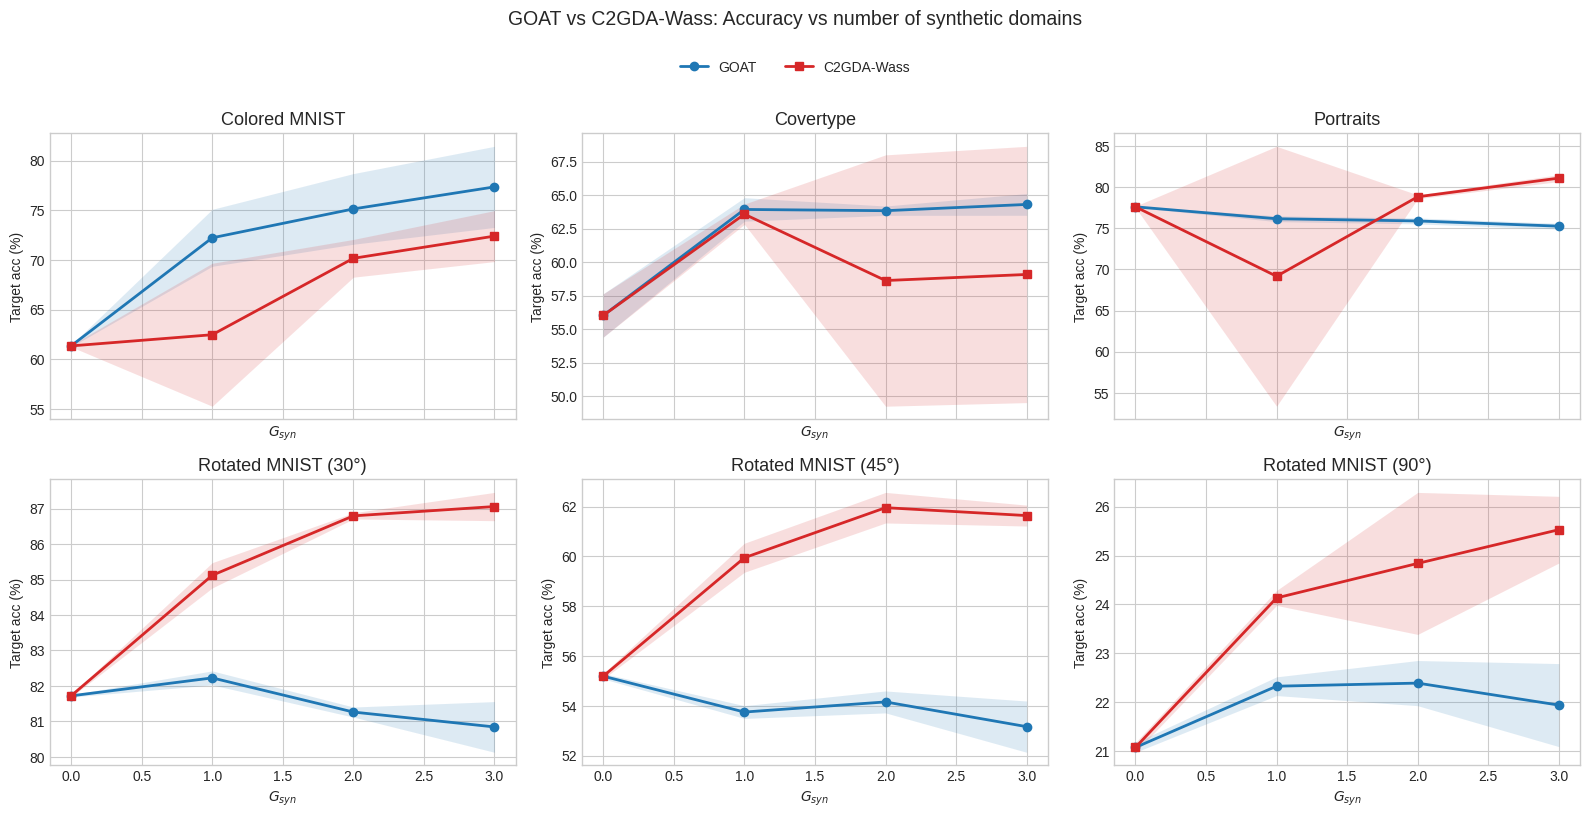

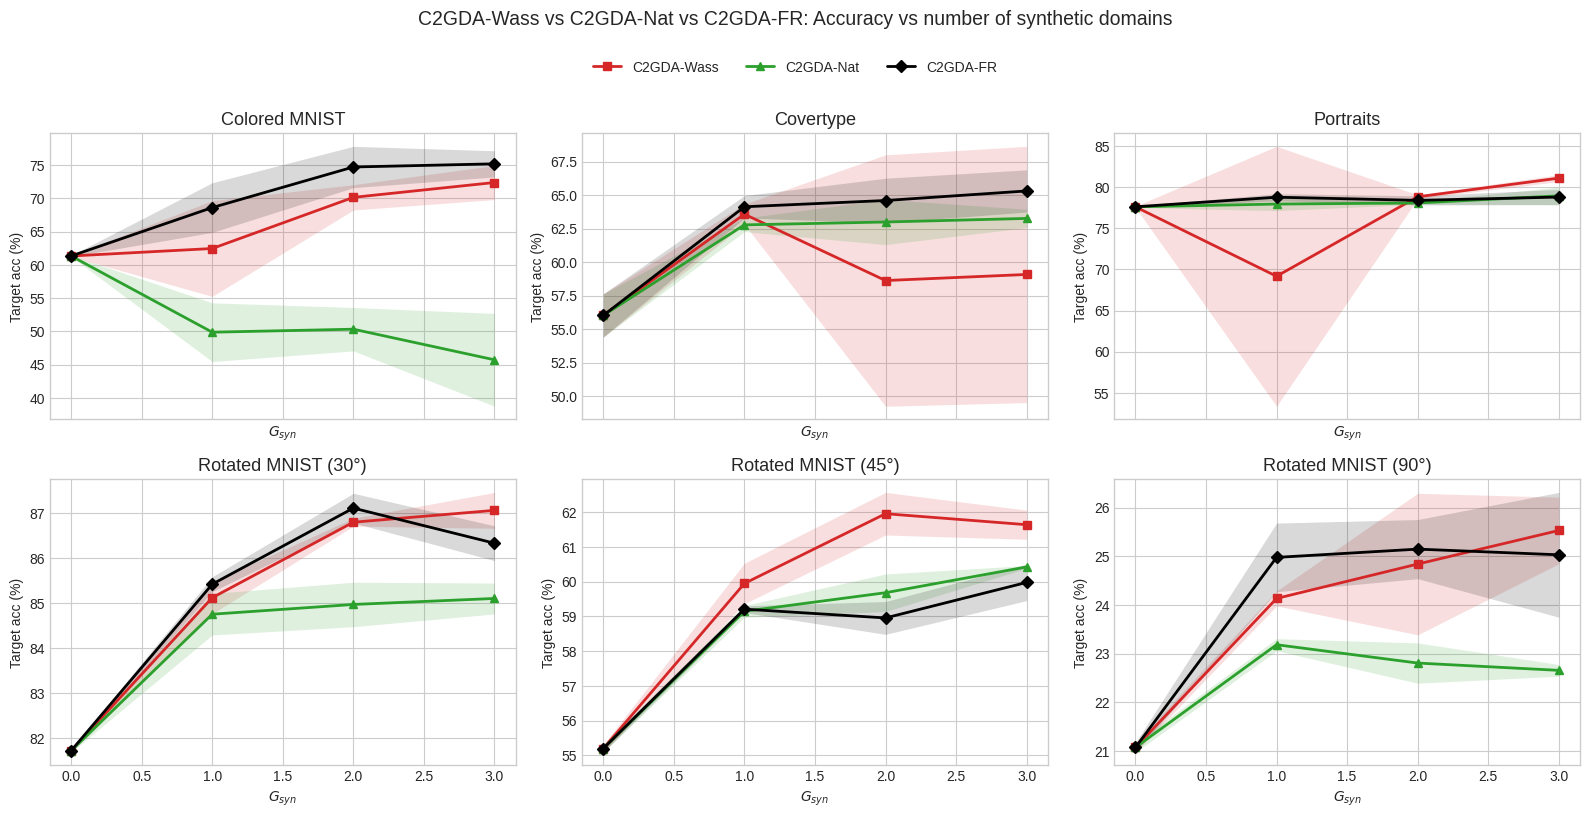

In [44]:
GT_TO_PLOT = 0
FILTERS_DESC = 'em_ensemble=False, em_match~prototype, em_select~bic'

if 'best' not in globals():
    if 'df_long' not in globals():
        raise NameError("`best` is not defined and `df_long` is unavailable. Run the long-table preparation cell first.")
    _plot_src = df_long.copy()
    _plot_src = _plot_src[
        (~_plot_src['em_ensemble'])
        & _plot_src['em_match'].str.contains('prototype', na=False)
        & _plot_src['em_select'].str.contains('bic', na=False)
    ]
    rank_df = _plot_src.sort_values(
        ['dataset', 'degree', 'gt', 'gen', 'method', 'acc_mean'],
        ascending=[True, True, True, True, True, False],
    )
    best = rank_df.groupby(['dataset', 'degree', 'gt', 'gen', 'method'], dropna=False).head(1).reset_index(drop=True)

plot_df = best[best['gt'] == GT_TO_PLOT].copy()
# plot_df = plot_df[~plot_df['dataset'].str.contains('covtype', case=False, na=False)].copy()  # optional

def ds_label(row):
    if row['dataset'] == 'rotated_mnist':
        return f"rot_mnist_t{int(row['degree'])}"
    return row['dataset']

plot_df['dataset_label'] = plot_df.apply(ds_label, axis=1)

# Pretty names for subplot titles
dataset_title = {
    'colored_mnist': 'Colored MNIST',
    'portraits': 'Portraits',
    'covtype': 'Covertype',
    'rot_mnist_t15': 'Rotated MNIST (15°)',
    'rot_mnist_t30': 'Rotated MNIST (30°)',
    'rot_mnist_t45': 'Rotated MNIST (45°)',
    'rot_mnist_t60': 'Rotated MNIST (60°)',
    'rot_mnist_t75': 'Rotated MNIST (75°)',
    'rot_mnist_t90': 'Rotated MNIST (90°)',
}
def pretty_ds(name):
    return dataset_title.get(name, name.replace('_', ' ').title())

datasets = sorted(plot_df['dataset_label'].unique().tolist())
# datasets = sorted(plot_df['dataset_label'].unique().tolist())
datasets = [d for d in datasets if d != 'rot_mnist_t60']  # drop 60° to keep 2x3

method_groups = [
    ('GOAT vs C2GDA-Wass', ['goat', 'goatcw']),
    ('C2GDA-Wass vs C2GDA-Nat vs C2GDA-FR', ['goatcw', 'eta', 'ours_fr']),
]
method_name = {
    'goat': 'GOAT',
    'goatcw': 'C2GDA-Wass',
    'eta': 'C2GDA-Nat',
    'ours_fr': 'C2GDA-FR',
}
method_style = {
    'goat': dict(color='#1f77b4', marker='o'),
    'goatcw': dict(color='#d62728', marker='s'),
    'eta': dict(color='#2ca02c', marker='^'),
    'ours_fr': dict(color='black', marker='D'),
}
import os
os.makedirs("figures_main", exist_ok=True)

for group_title, methods in method_groups:
    n = len(datasets)
    ncols = 3
    nrows = int(np.ceil(n / ncols)) if n > 0 else 1
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 3.8 * nrows), sharex=True)
    axes = np.array(axes).reshape(-1)

    for i, ds in enumerate(datasets):
        ax = axes[i]
        dsub = plot_df[plot_df['dataset_label'] == ds]
        shared_init = dsub.loc[dsub['gen'] == 0, 'acc_mean'].mean()
        shared_init_std = dsub.loc[dsub['gen'] == 0, 'acc_std'].fillna(0).mean()
        for m in methods:
            s = dsub[dsub['method'] == m].sort_values('gen').copy()
            if s.empty:
                continue
            if pd.notna(shared_init):
                if (s['gen'] == 0).any():
                    s.loc[s['gen'] == 0, 'acc_mean'] = shared_init
                    s.loc[s['gen'] == 0, 'acc_std'] = shared_init_std
                else:
                    s = pd.concat([
                        pd.DataFrame({'gen': [0], 'acc_mean': [shared_init], 'acc_std': [shared_init_std]}),
                        s,
                    ], ignore_index=True).sort_values('gen')
            x = s['gen'].to_numpy()
            y = s['acc_mean'].to_numpy()
            y_std = s['acc_std'].fillna(0).to_numpy()
            ax.plot(x, y, linewidth=2.0, label=method_name[m], **method_style[m])
            ax.fill_between(x, y - y_std, y + y_std, color=method_style[m]['color'], alpha=0.15, linewidth=0)

        ax.set_title(pretty_ds(ds), fontsize=13)
        ax.set_xlabel(r'$G_{syn}$')
        ax.set_ylabel('Target acc (%)')

    for j in range(len(datasets), len(axes)):
        axes[j].axis('off')

    if len(datasets) > 0:
        handles, labels = axes[0].get_legend_handles_labels()
        if handles:
            fig.legend(handles, labels, loc='upper center', ncol=len(methods), frameon=False, bbox_to_anchor=(0.5, 1.02))

    fig.suptitle(f'{group_title}: Accuracy vs number of synthetic domains', y=1.07, fontsize=14)
    fig.tight_layout()

    # save
    slug = group_title.lower().replace(' ', '_').replace('-', '')
    fig.savefig(f"figures_main/{slug}.png", dpi=300, bbox_inches="tight")
    fig.savefig(f"figures_main/{slug}.pdf", bbox_inches="tight")

    plt.show()


In [45]:
import pandas as pd

SEEDS = {0,1,2}
STD_TH = 4.0

s = pd.read_csv("results_summary_by_settings.csv")
all_df = pd.read_csv("results_all_with_settings.csv")

methods = ["goat","goatcw","eta","ours_fr"]

# long + best
rows = []
for m in methods:
    t = s[['dataset','degree','gt','gen','label_source','em_match','em_select','em_ensemble',
           'n_rows','n_files','n_seeds','seeds',f'{m}_mean',f'{m}_std',f'{m}_count']].copy()
    t = t.rename(columns={f'{m}_mean':'acc_mean', f'{m}_std':'acc_std', f'{m}_count':'acc_count'})
    t['method'] = m
    rows.append(t)
df_long = pd.concat(rows, ignore_index=True)

f = df_long[
    (~df_long['em_ensemble']) &
    df_long['em_match'].astype(str).str.contains('prototype', na=False) &
    df_long['em_select'].astype(str).str.contains('bic', na=False)
]
rank_df = f.sort_values(['dataset','degree','gt','gen','method','acc_mean'],
                        ascending=[True,True,True,True,True,False])
best = rank_df.groupby(['dataset','degree','gt','gen','method'], dropna=False).head(1).reset_index(drop=True)

all_f = all_df[
    (~all_df['em_ensemble']) &
    all_df['em_match'].astype(str).str.contains('prototype', na=False) &
    all_df['em_select'].astype(str).str.contains('bic', na=False)
].copy()

q_all = best[(best['n_files'] <= 3) & (best['acc_std'] > STD_TH)].copy()
print("q_all rows:", len(q_all))


q_all rows: 37


In [46]:
# Build rerun set from outlier rows (dataset, seed, gt, gen)
reruns = set()
outlier_rows = []

for _, r in q_all.iterrows():
    ds, gt, gen, m = r["dataset"], int(r["gt"]), int(r["gen"]), r["method"]
    sub = all_f[
        (all_f["dataset"] == ds) & (all_f["gt"] == gt) & (all_f["gen"] == gen)
    ][["seed", m]].dropna().copy()
    if sub.empty:
        continue

    sub["dev"] = (sub[m] - r["acc_mean"]).abs()
    bad = sub.sort_values("dev", ascending=False).iloc[0]
    bad_seed = int(bad["seed"])
    reruns.add((ds, bad_seed, gt, gen))

    seed_vals = ", ".join(
        f"s{int(x.seed)}={getattr(x, m):.3f}"
        for x in sub.sort_values("seed").itertuples(index=False)
    )
    outlier_rows.append({
        "dataset": ds,
        "gt": gt,
        "gen": gen,
        "method": m,
        "outlier_seed": bad_seed,
        "outlier_value": float(bad[m]),
        "acc_mean": float(r["acc_mean"]),
        "acc_std": float(r["acc_std"]),
        "seed_values": seed_vals,
    })

print("Num experiments to rerun:", len(reruns))

outlier_df = pd.DataFrame(outlier_rows).drop_duplicates(
    subset=["dataset", "gt", "gen", "method", "outlier_seed"]
).reset_index(drop=True)



Num experiments to rerun: 21


In [48]:
import os
import pandas as pd

# 1) Dedup reruns robustly
rerun_df = pd.DataFrame(sorted(reruns), columns=["dataset", "seed", "gt", "gen"])
rerun_df = rerun_df.drop_duplicates(subset=["dataset", "seed", "gt", "gen"]).reset_index(drop=True)

# covtype first, then dataset/seed/gt/gen
rerun_df["_prio"] = (rerun_df["dataset"] != "covtype").astype(int)
rerun_df = rerun_df.sort_values(["_prio", "dataset", "seed", "gt", "gen"]).drop(columns="_prio").reset_index(drop=True)

rerun_list = list(rerun_df.itertuples(index=False, name=None))
print("Num unique experiments to rerun:", len(rerun_list))

# 2) Attach outlier info to rerun list
rerun_view = rerun_df.merge(
    outlier_df,
    left_on=["dataset", "seed", "gt", "gen"],
    right_on=["dataset", "outlier_seed", "gt", "gen"],
    how="left",
).sort_values(["dataset", "gt", "gen", "seed", "method"], na_position="last").reset_index(drop=True)

display(rerun_view[["dataset", "seed", "gt", "gen", "method", "outlier_value", "acc_mean", "acc_std", "seed_values"]])

dataset_cli_map = {
    "colored_mnist": "color_mnist",
    "rotated_mnist": "mnist",
    "portraits": "portraits",
    "covtype": "covtype",
}

# 3) Write deduped shell script with dynamic GPU selection
script_path = "./rerun_experiments.sh"
with open(script_path, "w") as f:
    f.write("#!/usr/bin/env bash\nset -euo pipefail\ncd ~/GOAT\n\n")
    f.write('LOG_ROOT="${LOG_ROOT:-logs_rerun}"\n\n')
    f.write(
        "pick_gpu() {\n"
        "  nvidia-smi --query-gpu=index,memory.used,utilization.gpu --format=csv,noheader,nounits |\n"
        "  awk -F',' '{gsub(/ /,"",$1); gsub(/ /,"",$2); gsub(/ /,"",$3); score=$2 + 200*$3; print score, $1}' |\n"
        "  sort -n | head -1 | awk '{print $2}'\n"
        "}\n\n"
    )
    f.write(
        "run_exp() {\n"
        "  local ds=\"$1\" seed=\"$2\" gt=\"$3\" gen=\"$4\"\n"
        "  local gpu\n"
        "  gpu=\"$(pick_gpu)\"\n"
        "  echo \"[GPU ${gpu}] ${ds} seed=${seed} gt=${gt} gen=${gen}\"\n"
        "  OMP_NUM_THREADS=4 MKL_NUM_THREADS=4 OPENBLAS_NUM_THREADS=4 NUMEXPR_NUM_THREADS=4 CUDA_VISIBLE_DEVICES=\"${gpu}\" python experiment_refrac.py --log-root \"${LOG_ROOT}\" --dataset \"${ds}\" --label-source pseudo --em-match prototypes --seed \"${seed}\" --gt-domains \"${gt}\" --generated-domains \"${gen}\" --num-workers 0\n"
        "}\n\n"
    )

    for ds, s, gt, gen in rerun_list:
        ds_cli = dataset_cli_map.get(ds, ds)
        f.write(
            f'rm -f "${{LOG_ROOT}}/{ds_cli}/s{s}/test_acc_dim54_int{gt}_gen{gen}_pseudo_prototypes_bic.txt" '
            f'"${{LOG_ROOT}}/{ds_cli}/s{s}/test_acc_dim54_int{gt}_gen{gen}_pseudo_prototypes_bic_curves.jsonl" '
            f'"${{LOG_ROOT}}/{ds_cli}/s{s}/test_acc_dim2048_int{gt}_gen{gen}_pseudo_prototypes_bic.txt" '
            f'"${{LOG_ROOT}}/{ds_cli}/s{s}/test_acc_dim2048_int{gt}_gen{gen}_pseudo_prototypes_bic_curves.jsonl"\n'
        )
        f.write(f'run_exp "{ds_cli}" "{s}" "{gt}" "{gen}"\n\n')

    f.write("python collect_result.py\n")

os.chmod(script_path, 0o755)

print("Saved deduped commands to:", script_path)
print("Run with:")
print(f"bash {script_path}")



Num unique experiments to rerun: 21


,dataset,seed,gt,gen,method,outlier_value,acc_mean,acc_std,seed_values
0,colored_mnist,0,0,1,goatcw,70.72,62.467,7.200,"s0=70.720, s1=59.210, s2=57.470"
1,colored_mnist,2,0,1,eta,54.96,49.873,4.417,"s0=47.650, s1=47.010, s2=54.960"
2,colored_mnist,0,0,3,eta,37.78,45.717,6.982,"s0=37.780, s1=48.460, s2=50.910"
3,colored_mnist,0,0,3,goat,82.07,77.357,4.085,"s0=82.070, s1=75.160, s2=74.840"
4,colored_mnist,0,1,1,eta,72.26,65.200,6.819,"s0=72.260, s1=64.690, s2=58.650"
5,colored_mnist,1,1,2,eta,61.23,66.220,4.458,"s0=69.810, s1=61.230, s2=67.620"
6,colored_mnist,1,1,3,eta,58.27,63.860,5.091,"s0=65.080, s1=58.270, s2=68.230"
7,colored_mnist,1,2,2,eta,69.67,74.710,4.459,"s0=78.140, s1=69.670, s2=76.320"
8,colored_mnist,1,2,3,eta,70.47,74.850,4.133,"s0=78.680, s1=70.470, s2=75.400"
9,colored_mnist,2,3,2,eta,75.58,70.753,4.752,"s0=70.600, s1=66.080, s2=75.580"


Saved deduped commands to: ./rerun_experiments.sh
Run with:
bash ./rerun_experiments.sh


In [ ]:
rerun_view.shape

(36, 10)

## 9) Best Setting per Method and Scenario

For each `(dataset, degree, gt, gen, method)`, keep the highest `acc_mean` row.


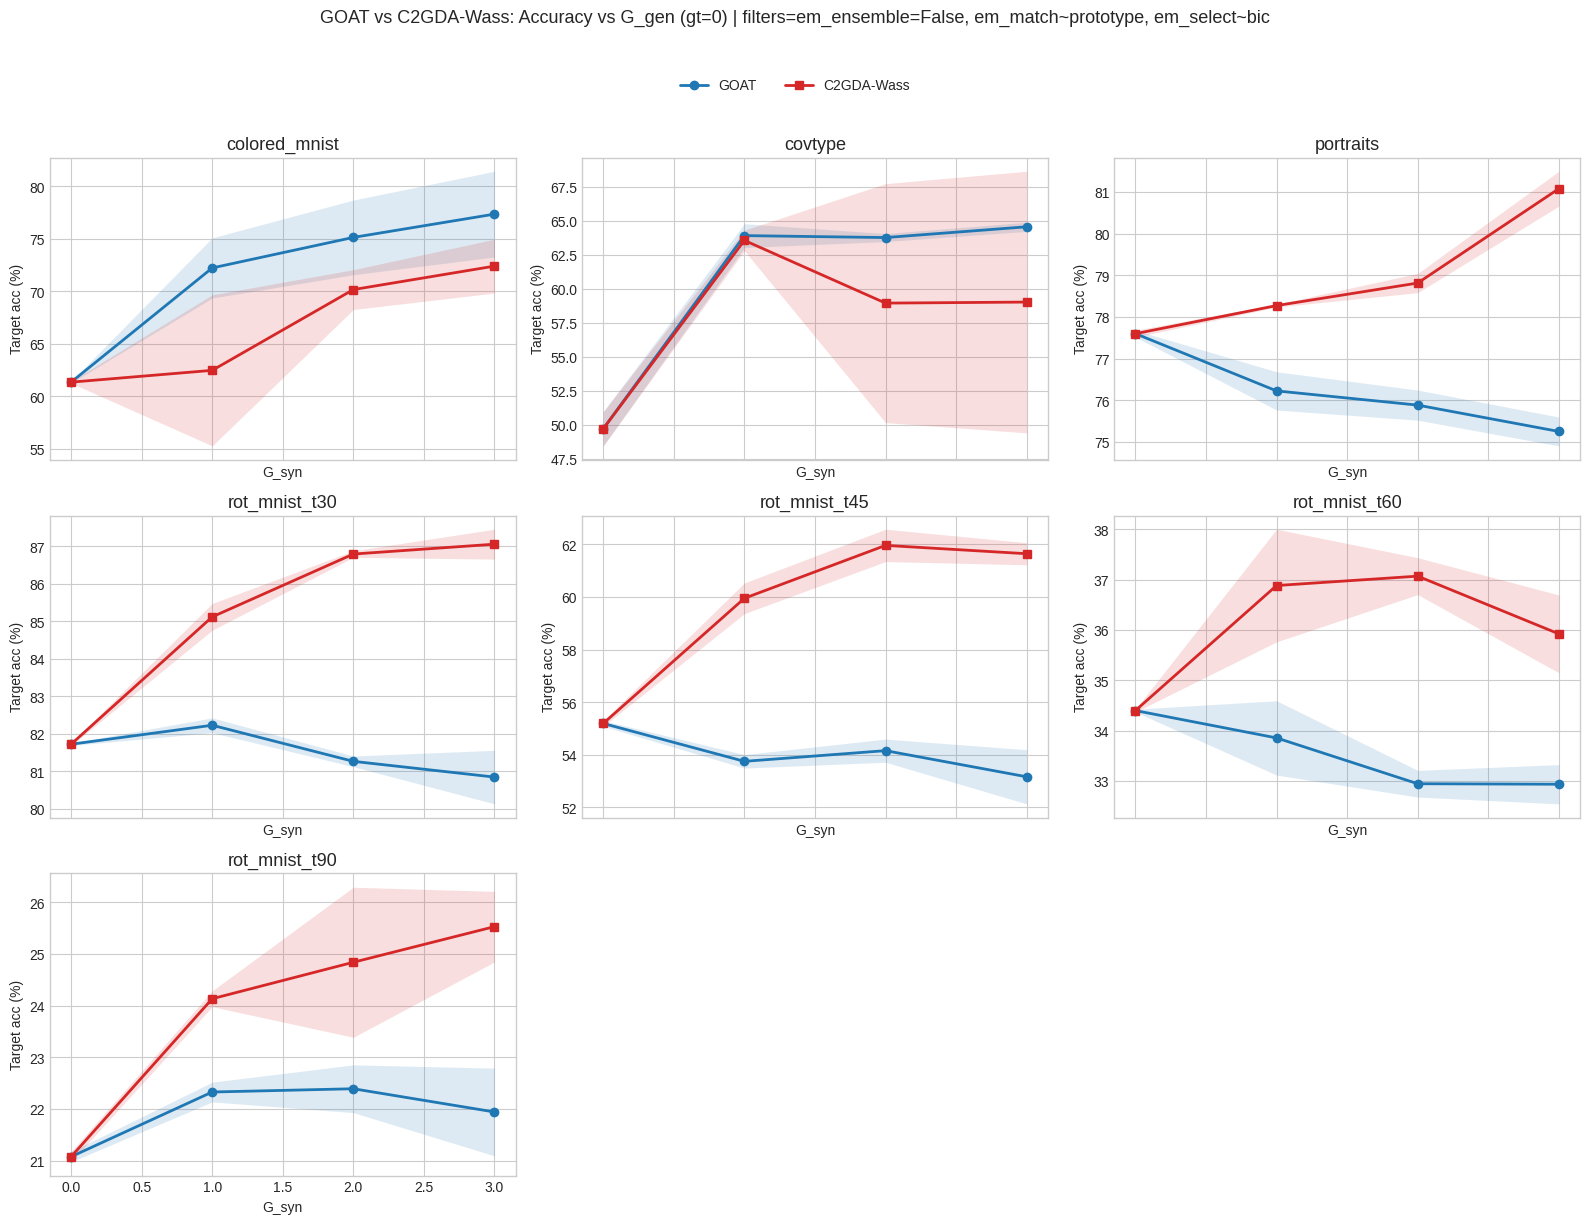

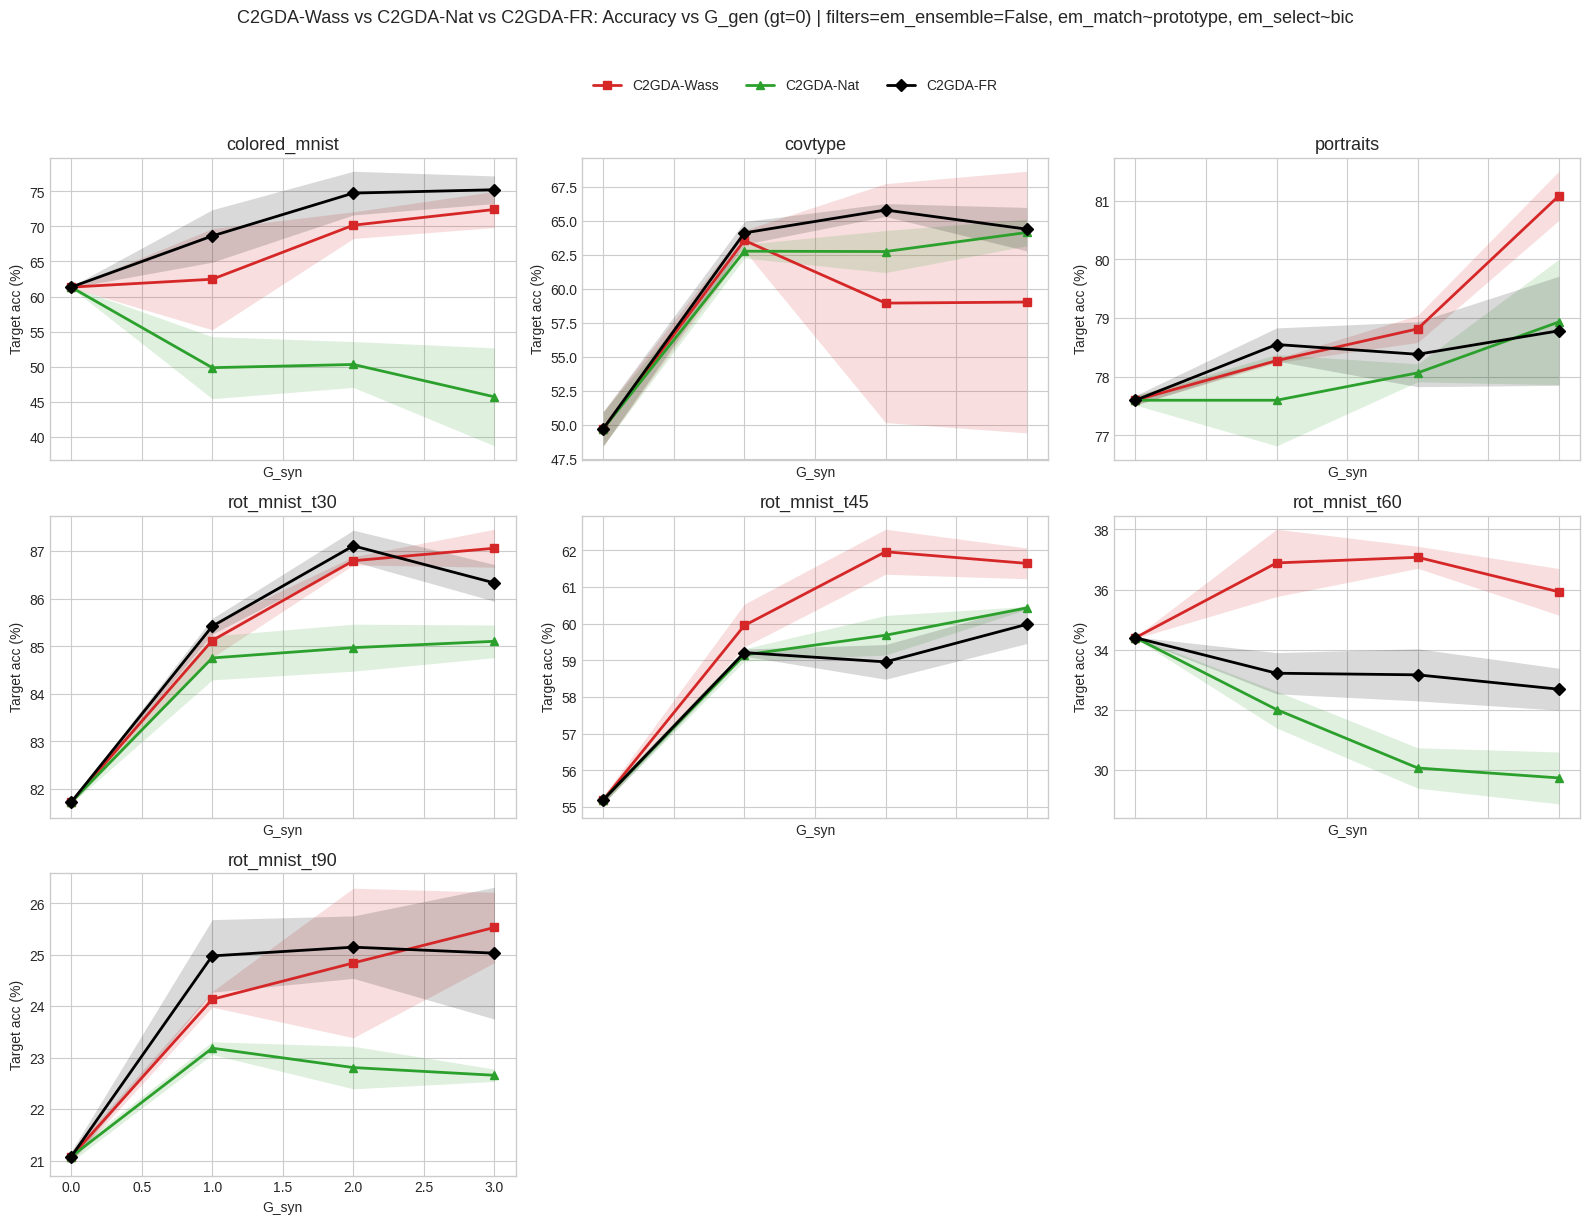

In [15]:
if 'df_long' not in globals():
    raise NameError("`df_long` is not defined. Run the long-table preparation cell first.")
df_long = df_long[(~df_long['em_ensemble']) & df_long['em_match'].str.contains('prototype', na=False) & df_long['em_select'].str.contains('bic', na=False)]
rank_df = df_long.sort_values(
    ['dataset', 'degree', 'gt', 'gen', 'method', 'acc_mean'],
    ascending=[True, True, True, True, True, False],
)
best = rank_df.groupby(['dataset', 'degree', 'gt', 'gen', 'method'], dropna=False).head(1).reset_index(drop=True)

best[best['dataset'].str.contains('colored_mnist')][
    ['dataset','degree','gt','gen','method','acc_mean','acc_std','label_source','em_match','em_select','em_ensemble','seeds']
]

best[
    ['dataset','degree','gt','gen','method','acc_mean','acc_std','label_source','em_match','em_select','em_ensemble','seeds','acc_mean','acc_std']
]


GT_TO_PLOT = 0
FILTERS_DESC = 'em_ensemble=False, em_match~prototype, em_select~bic'

if 'best' not in globals():
    if 'df_long' not in globals():
        raise NameError("`best` is not defined and `df_long` is unavailable. Run the long-table preparation cell first.")
    _plot_src = df_long.copy()
    _plot_src = _plot_src[
        (~_plot_src['em_ensemble'])
        & _plot_src['em_match'].str.contains('prototype', na=False)
        & _plot_src['em_select'].str.contains('bic', na=False)
    ]
    rank_df = _plot_src.sort_values(
        ['dataset', 'degree', 'gt', 'gen', 'method', 'acc_mean'],
        ascending=[True, True, True, True, True, False],
    )
    best = rank_df.groupby(['dataset', 'degree', 'gt', 'gen', 'method'], dropna=False).head(1).reset_index(drop=True)

plot_df = best[best['gt'] == GT_TO_PLOT].copy()


def ds_label(row):
    if row['dataset'] == 'rotated_mnist':
        return f"rot_mnist_t{int(row['degree'])}"
    return row['dataset']


plot_df['dataset_label'] = plot_df.apply(ds_label, axis=1)
datasets = sorted(plot_df['dataset_label'].unique().tolist())
method_groups = [
    ('GOAT vs C2GDA-Wass', ['goat', 'goatcw']),
    ('C2GDA-Wass vs C2GDA-Nat vs C2GDA-FR', ['goatcw', 'eta', 'ours_fr']),
]
method_name = {
    'goat': 'GOAT',
    'goatcw': 'C2GDA-Wass',
    'eta': 'C2GDA-Nat',
    'ours_fr': 'C2GDA-FR',
}
method_style = {
    'goat': dict(color='#1f77b4', marker='o'),
    'goatcw': dict(color='#d62728', marker='s'),
    'eta': dict(color='#2ca02c', marker='^'),
    'ours_fr': dict(color='black', marker='D'),
}

for group_title, methods in method_groups:
    n = len(datasets)
    ncols = 3
    nrows = int(np.ceil(n / ncols)) if n > 0 else 1
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 3.8 * nrows), sharex=True)
    axes = np.array(axes).reshape(-1)

    for i, ds in enumerate(datasets):
        ax = axes[i]
        dsub = plot_df[plot_df['dataset_label'] == ds]
        shared_init = dsub.loc[dsub['gen'] == 0, 'acc_mean'].mean()
        shared_init_std = dsub.loc[dsub['gen'] == 0, 'acc_std'].fillna(0).mean()
        for m in methods:
            s = dsub[dsub['method'] == m].sort_values('gen').copy()
            if s.empty:
                continue
            if pd.notna(shared_init):
                if (s['gen'] == 0).any():
                    s.loc[s['gen'] == 0, 'acc_mean'] = shared_init
                    s.loc[s['gen'] == 0, 'acc_std'] = shared_init_std
                else:
                    s = pd.concat([
                        pd.DataFrame({'gen': [0], 'acc_mean': [shared_init], 'acc_std': [shared_init_std]}),
                        s,
                    ], ignore_index=True).sort_values('gen')
            x = s['gen'].to_numpy()
            y = s['acc_mean'].to_numpy()
            y_std = s['acc_std'].fillna(0).to_numpy()
            ax.plot(
                x,
                y,
                linewidth=2.0,
                label=method_name[m],
                **method_style[m],
            )
            ax.fill_between(
                x,
                y - y_std,
                y + y_std,
                color=method_style[m]['color'],
                alpha=0.15,
                linewidth=0,
            )
        ax.set_title(ds, fontsize=13)
        ax.set_xlabel('G_syn')
        ax.set_ylabel('Target acc (%)')

    for j in range(len(datasets), len(axes)):
        axes[j].axis('off')

    if len(datasets) > 0:
        handles, labels = axes[0].get_legend_handles_labels()
        if handles:
            fig.legend(handles, labels, loc='upper center', ncol=len(methods), frameon=False, bbox_to_anchor=(0.5, 1.02))

    fig.suptitle(f'{group_title}: Accuracy vs G_gen (gt={GT_TO_PLOT}) | filters={FILTERS_DESC}', y=1.07, fontsize=13)
    fig.tight_layout()
    plt.show()




## 10) Pairwise Method Deltas (Split)

Group A compares `goatcw` against `goat`; Group B compares `eta` and `ours_fr` against `goatcw`.


In [ ]:
wide = df_long.pivot_table(
    index=['dataset','degree','gt','gen','label_source','em_match','em_select','em_ensemble','seeds'],
    columns='method',
    values='acc_mean',
    aggfunc='first',
).reset_index()

if {'goat', 'goatcw'}.issubset(wide.columns):
    wide['delta_goatcw_minus_goat'] = wide['goatcw'] - wide['goat']
    display(
        wide[['dataset','degree','gt','gen','goat','goatcw','delta_goatcw_minus_goat']]
        .sort_values(['dataset','degree','gt','gen'])
        .head(20)
    )
else:
    print('Missing columns for Group A delta: goat/goatcw')

if {'goatcw', 'eta', 'ours_fr'}.issubset(wide.columns):
    wide['delta_eta_minus_goatcw'] = wide['eta'] - wide['goatcw']
    wide['delta_fr_minus_goatcw'] = wide['ours_fr'] - wide['goatcw']
    display(
        wide[['dataset','degree','gt','gen','goatcw','eta','ours_fr','delta_eta_minus_goatcw','delta_fr_minus_goatcw']]
        .sort_values(['dataset','degree','gt','gen'])
        .head(20)
    )
else:
    print('Missing columns for Group B deltas: goatcw/eta/ours_fr')


saved: 18 jobs -> /tmp/rerun_list_all.txt


## 11) High-Variance Rows (Diagnostics)

These rows are useful to inspect unstable settings.


In [20]:
print("all datasets in all_df:", sorted(all_df['dataset'].dropna().unique()))
print("after prototype+bic filter:", sorted(all_f['dataset'].dropna().unique()))
print("after std/missing selection:", sorted(q_all['dataset'].dropna().unique()))


all datasets in all_df: ['covtype']
after prototype+bic filter: ['covtype']
after std/missing selection: ['colored_mnist', 'covtype']


## 12) Optional Exports

Uncomment and run this cell when you want CSV outputs for reports or scripts.


In [12]:
OUT_DIR = Path('analysis_outputs')
OUT_DIR.mkdir(parents=True, exist_ok=True)

df_long.to_csv(OUT_DIR / 'results_summary_long.csv', index=False)
best.to_csv(OUT_DIR / 'best_setting_per_method.csv', index=False)
wide.to_csv(OUT_DIR / 'pairwise_deltas.csv', index=False)

print('Wrote:', OUT_DIR)


Wrote: analysis_outputs


## 13) Key Takeaways (Fill After Running)

Use this section to record final conclusions from the run:
- Which method wins most often?
- Which datasets/settings are most sensitive to `gen`?
- Where is variance too high for confident claims?
